# Import torch & device info


In [ ]:
%matplotlib inline

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'avaiable device : %s' % device)
# for reproducibility
torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

avaiable device : cuda


In [ ]:
!nvidia-smi

Sat Aug 22 23:42:24 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8    10W /  70W |     10MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Prepare data


The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



In [ ]:
#CIFAR-10 dataset

batch_size = 4

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.RandomHorizontalFlip(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

print(f'total training samples : {batch_size * len(trainloader)}')
print(f'total test samples : {batch_size * len(testloader)}')

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
total training samples : 50000
total test samples : 10000


Let us show some of the training images, for fun.



truck   dog horse truck 



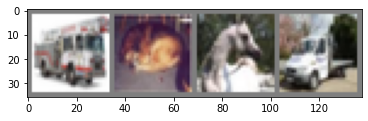

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
  img = img / 2 + 0.5 #unnormalize
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0))) # torch : CWH --> matplotlib : WHC

#get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

#show images
imshow(torchvision.utils.make_grid(images))
#print labels
print(''.join('%5s ' % classes[labels[j]] for j in range(4)))


# Define my Neural Network


In [ ]:
# Define my CNN Model (2 conv layers)
class myNN(torch.nn.Module):

    def __init__(self):
        super(myNN, self).__init__()
        # Torch tensor dim. (bath_size, C, H, W)
        # L1 ImgIn shape=(batch_size, 3,  32, 32)
        #    Conv     -> (batch_size, 32, 32, 32)
        #    Relu     -> (batch_size, 32, 32, 32)
        #    Pool     -> (batch_size, 32, 16, 16)
        self.conv1 = torch.nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.relu1 = torch.nn.ReLU()
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2)

        # L2 ImgIn shape=(batch_size, 32, 16, 16)
        #    Conv      ->(batch_size, 64, 16, 16)
        #    Relu      ->(batch_size, 64, 16, 16)
        #    Pool      ->(batch_size, 64,  8,  8)
        self.conv2 = torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.relu2 = torch.nn.ReLU()
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2)

        # Final FC 8x8x64 inputs -> 10 outputs
        self.fc = torch.nn.Linear(8 * 8 * 64, 10, bias=True)
        torch.nn.init.xavier_uniform_(self.fc.weight)

    def forward(self, x):

        out = self.conv1(x)
        out = self.relu1(out)
        out = self.pool1(out)
        #out = self.pool1(self.relu1(self.conv1(x)))

        out = self.conv2(out)
        out = self.relu2(out)
        out = self.pool2(out)
        #out = self.pool2(self.relu2(self.conv2(x)))
        # dim : (batch_size, 64, 8, 8)

        out = out.view(out.size(0), -1)   # Flatten them for FC --> dim : (batch_size, 8*8*64)
        out = self.fc(out) # dim : (batch_size, 10)
        return out

## Pratice `view` funcion

In [ ]:
# Practice for View
a = torch.arange(1, 17) #vector
print(a)
#a.shape
aa = a.view(-1,1) # [16,1]
print(aa)
print(f'aa.shape : {aa.shape}')
bb = a.view(1, -1) #[16, 1]
print('bb')
print(bb)
print(f'bb.shape : {bb.shape}')

tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16])
tensor([[ 1],
        [ 2],
        [ 3],
        [ 4],
        [ 5],
        [ 6],
        [ 7],
        [ 8],
        [ 9],
        [10],
        [11],
        [12],
        [13],
        [14],
        [15],
        [16]])
aa.shape : torch.Size([16, 1])
bb
tensor([[ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]])
bb.shape : torch.Size([1, 16])


# Set training protocols

In [ ]:
# instantiate CNN model
model = myNN().to(device)

In [ ]:
# hyperparamters
learning_rate = 0.001
training_epochs = 2

# define cost/loss * optmizer
criterion = torch.nn.CrossEntropyLoss().to(device) # Softmax is internally computed.
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training myNN

In [ ]:
total_batch = len(trainloader)
print("Training Start!")

for epoch in range(training_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)


        optimizer.zero_grad() # set gradients to zero

        # forward + backward + optimize
        outputs = model(inputs) # forward myNN
        loss = criterion(outputs, labels) #compute the loss
        loss.backward() #back prop
        optimizer.step() #weight update

        running_loss += loss.item() / total_batch

    print('[Epoch: {:>4}] loss = {:>.9}'.format(epoch + 1, running_loss))

print('Training Finished !')

Training Start!
[Epoch:    1] loss = 1.25329117
[Epoch:    2] loss = 0.975761312
Training Finished !


GroundTruth:   deer plane  deer   cat


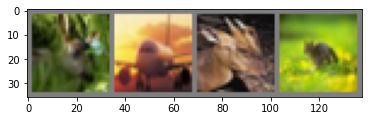

In [ ]:
dataiter = iter(testloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

Okay, now let us see what the neural network thinks these examples above are:



In [ ]:
images = images.to(device)
outputs = model(images)

In [ ]:
print(outputs.shape) # [4, 10]
#predicted means argmax
_, predicted = torch.max(outputs, 1) # along with dim=1 return (max_values, indices)
print('predicted:', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

torch.Size([4, 10])
predicted:  deer   cat  frog  bird


# Validate myNN

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        model.eval()
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0) # the number of test images
        correct += (predicted == labels).sum().item()
print('Accuracy of the network on the 10000 test images: %d %%' %(100 * correct/total))

Accuracy of the network on the 10000 test images: 67 %


In [ ]:
class_correct = list(0. for i in(range(10))) # [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
class_total = list(0. for i in range(10))
with torch.no_grad():
  for data in testloader:
    images, labels = data
    images = images.to(device)
    labels = labels.to(device)
    model.eval()
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)
    c = (predicted == labels).squeeze()
    for i in range(4):
        label = labels[i]
        class_correct[label] += c[i].item()
        class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 69 %
Accuracy of   car : 74 %
Accuracy of  bird : 52 %
Accuracy of   cat : 53 %
Accuracy of  deer : 57 %
Accuracy of   dog : 60 %
Accuracy of  frog : 71 %
Accuracy of horse : 79 %
Accuracy of  ship : 72 %
Accuracy of truck : 80 %


# Practice
---


## Define ResNet
https://arxiv.org/abs/1512.03385

In [ ]:
def conv3x3(in_planes, out_planes, stride=1, padding=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=padding, bias=False)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride,
                     bias=False)


In [ ]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None,
                 norm_layer=None):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d

        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None,
                 norm_layer=None):
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, planes)
        self.bn1 = norm_layer(planes)
        self.conv2 = conv3x3(planes, planes, stride)
        self.bn2 = norm_layer(planes)
        self.conv3 = conv1x1(planes, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=10, norm_layer=None):
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.stem = nn.Sequential(
            nn.Conv2d(3, self.inplanes, kernel_size=7, stride=1, padding=3, bias=False), # preseve resoltuion : 32x32
            norm_layer(self.inplanes),
            nn.ReLU(inplace=True)
        )

        self.stage2 = self._make_layer(block,  64, layers[0])
        self.stage3 = self._make_layer(block, 128, layers[1], stride=2)  # 32x32 --> 16x16
        self.stage4 = self._make_layer(block, 256, layers[2], stride=2)  # 16x16 --> 8x8
        self.stage5 = self._make_layer(block, 512, layers[3], stride=1)  # preserve resolution : 8x8
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))                      # Global Average Pooling (GAP) : 512x8x8 --> 512x1x1
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        # weight initaliztaion
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)


    def _make_layer(self, block, planes, blocks, stride=1):
        norm_layer = self._norm_layer
        downsample = None

        # stage changing or identity perturbation with proper channels for identity addition
        if stride != 1 or self.inplanes != planes * block.expansion:
            # projection shortcut
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def forward(self, x):

        x = self.stem(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.stage4(x)
        x = self.stage5(x)

        x = self.avgpool(x)
        # print(f'gap shape : {x.shape}')
        x = torch.flatten(x, start_dim=1)
        # print(f'flatten shape : {x.shape}')
        x = self.fc(x)

        return x



def _resnet(block, layers):
    model = ResNet(block, layers)
    return model

In [ ]:
def resnet11():
    return _resnet( BasicBlock, [1, 1, 1, 1])

def resnet18():
    return _resnet( BasicBlock, [2, 2, 2, 2])

def resnet34():
    return _resnet( BasicBlock, [3, 4, 6, 3])

def resnet50():
    return _resnet( Bottleneck, [3, 4, 6, 3])

def resnet101():
    return _resnet( Bottleneck, [3, 4, 23, 3])

## Model check

In [ ]:
input_temp = torch.randn(1, 3, 32, 32)
model = resnet50()
print(model)
# output = model(input_temp)

ResNet(
  (stem): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (stage2): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum

In [ ]:
# check the number of parameters
def compute_params(model):
    return format(np.sum([p.numel() for p in model.parameters()]).item(), ",")

print(compute_params(model))

25,194,378


## Define training function

In [ ]:
def do_train(model, trainloader, init_lr=0.1, training_epochs=10, step=3):

    # instantiate CNN model
    model = model.to(device)
    # hyperparamters
    # learning_rate = 0.1
    # training_epochs = 5

    # define cost/loss * optmizer
    criterion = torch.nn.CrossEntropyLoss().to(device) # Softmax is internally computed.
    optimizer = torch.optim.Adam(model.parameters(), lr=init_lr)
    if step == 0 :
        pass
    else:
        lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step, gamma=0.1)

    print("Training start !")

    for epoch in range(training_epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad() # set gradients to zero

            # forward + backward + optimize
            outputs = model(inputs) # forward myNN
            loss = criterion(outputs, labels) #compute the loss
            loss.backward() #back prop
            optimizer.step() #weight update

            # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print('[%d, %5d] lr: %.6f   loss: %.3f ' %
                    (epoch + 1, i + 1,  lr_scheduler.get_last_lr()[0], running_loss / 2000))
                running_loss = 0.0

        lr_scheduler.step()

    print('Training finished !')

In [ ]:
model = resnet11()
do_train(model, trainloader, init_lr=0.01, training_epochs=10, step=3)

Training start !
[1,  2000] lr: 0.010000   loss: 2.119 
[1,  4000] lr: 0.010000   loss: 1.861 
[1,  6000] lr: 0.010000   loss: 1.682 
[1,  8000] lr: 0.010000   loss: 1.607 
[1, 10000] lr: 0.010000   loss: 1.532 
[1, 12000] lr: 0.010000   loss: 1.446 
[2,  2000] lr: 0.010000   loss: 1.339 
[2,  4000] lr: 0.010000   loss: 1.272 
[2,  6000] lr: 0.010000   loss: 1.205 
[2,  8000] lr: 0.010000   loss: 1.148 
[2, 10000] lr: 0.010000   loss: 1.102 
[2, 12000] lr: 0.010000   loss: 1.043 
[3,  2000] lr: 0.010000   loss: 0.959 
[3,  4000] lr: 0.010000   loss: 0.948 
[3,  6000] lr: 0.010000   loss: 0.929 
[3,  8000] lr: 0.010000   loss: 0.884 
[3, 10000] lr: 0.010000   loss: 0.873 
[3, 12000] lr: 0.010000   loss: 0.851 
[4,  2000] lr: 0.001000   loss: 0.699 
[4,  4000] lr: 0.001000   loss: 0.680 
[4,  6000] lr: 0.001000   loss: 0.642 
[4,  8000] lr: 0.001000   loss: 0.621 
[4, 10000] lr: 0.001000   loss: 0.642 
[4, 12000] lr: 0.001000   loss: 0.597 
[5,  2000] lr: 0.001000   loss: 0.584 
[5,  400

##Define validation function

In [ ]:
def do_validate(model, testloader):
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print('Accuracy of the network on the 10000 test images: %0.4f %%' %(100 * correct/total))

In [ ]:
do_validate(model, testloader)

Accuracy of the network on the 10000 test images: 79 %
